In [42]:
import importlib

dict_keys([(28, np.float64(20.0)), (28, np.float64(120.0)), (68, np.float64(120.0)), (92, np.float64(120.0)), (95, np.float64(120.0))])


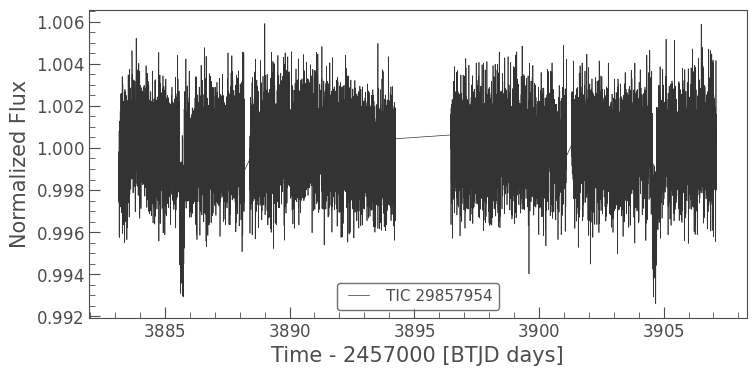

In [53]:
import get_data_from_id
importlib.reload(get_data_from_id)
from get_data_from_id import download_all_sectors
data = download_all_sectors(29857954)
print(data.keys())
lc0 = data[(95, np.float64(120.0))]
lc0.plot()
plt.show()

SearchResult containing 5 data products.

 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 01 2018 TESScut    1426 TIC 29857954      0.0
  1 TESS Sector 28 2020 TESScut     475 TIC 29857954      0.0
  2 TESS Sector 68 2023 TESScut     158 TIC 29857954      0.0
  3 TESS Sector 95 2025 TESScut     158 TIC 29857954      0.0
  4 TESS Sector 92 2025 TESScut     158 TIC 29857954      0.0


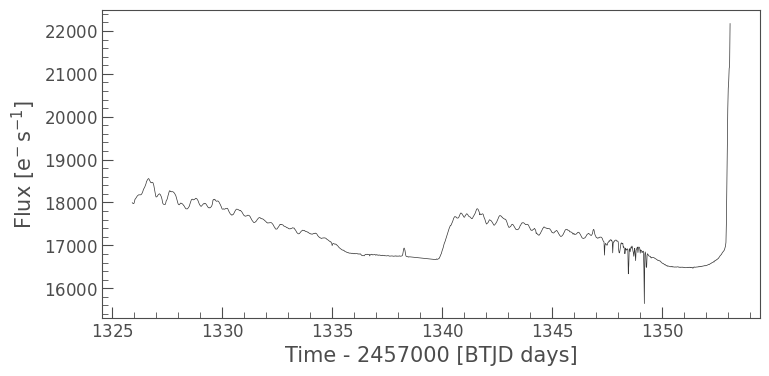

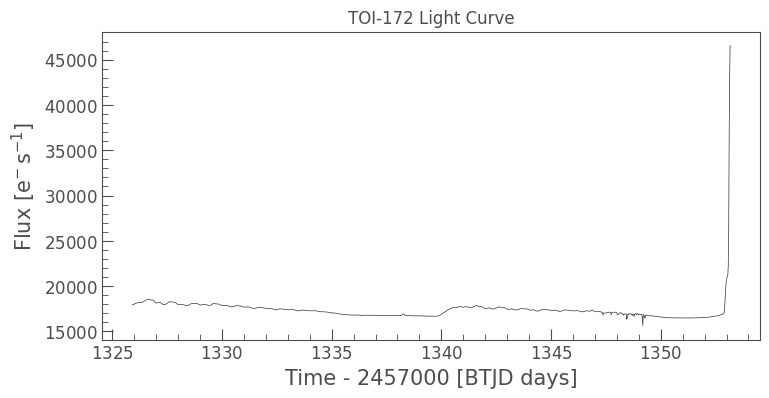

In [ ]:
import lightkurve as lk
import matplotlib.pyplot as plt

# TOI-172 的 TIC 号
tic_id = 29857954

# 1. 搜索 TESS 的 cutout 数据（FFI 图像）
search_result = lk.search_tesscut(f"TIC {tic_id}")
print(search_result)

# 2. 下载第一个结果（通常是 Sector 1）
tpf = search_result[0].download(cutout_size=15)  # 15x15 像素的小视场

# 3. 将像素数据转换为光变曲线
lc = tpf.to_lightcurve(aperture_mask="threshold")

lc_clean = lc.remove_outliers(sigma=10)   # 你现在 spike 给我看过，10 比较保险
lc_clean.plot()


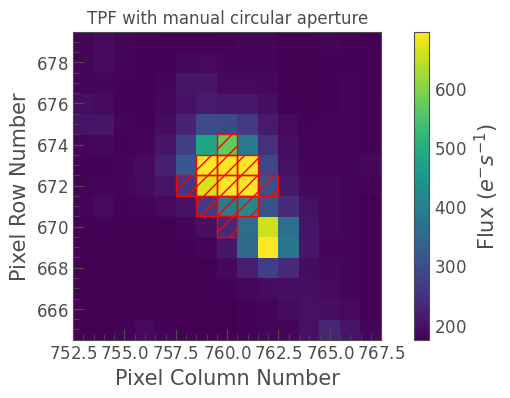

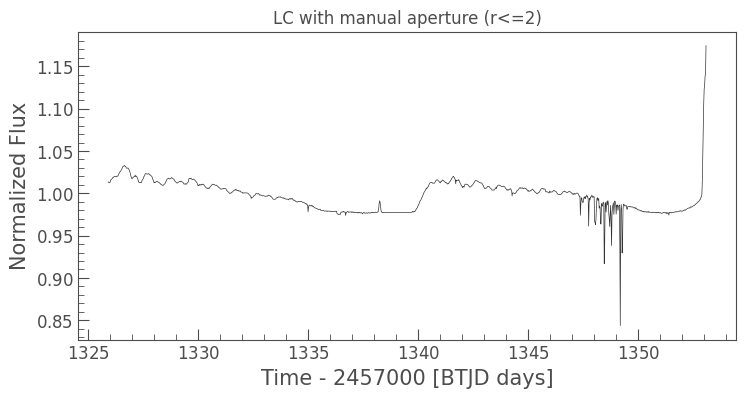

In [18]:
ny, nx = tpf.shape[1], tpf.shape[2]   # 像素网格大小
y0, x0 = ny//2, nx//2                 # 中心像素
Y, X = np.indices((ny, nx))
r = np.sqrt((X - x0)**2 + (Y - y0)**2)


# 圈一个半径 2 像素的圆形 aperture
manual_mask = r <= 2

tpf.plot(aperture_mask=manual_mask)
plt.title("TPF with manual circular aperture")
plt.show()

lc2 = tpf.to_lightcurve(aperture_mask=manual_mask).remove_nans().normalize().remove_outliers(sigma=10)
lc2.plot()
plt.title("LC with manual aperture (r<=2)")
plt.show()


<Figure size 1000x400 with 0 Axes>

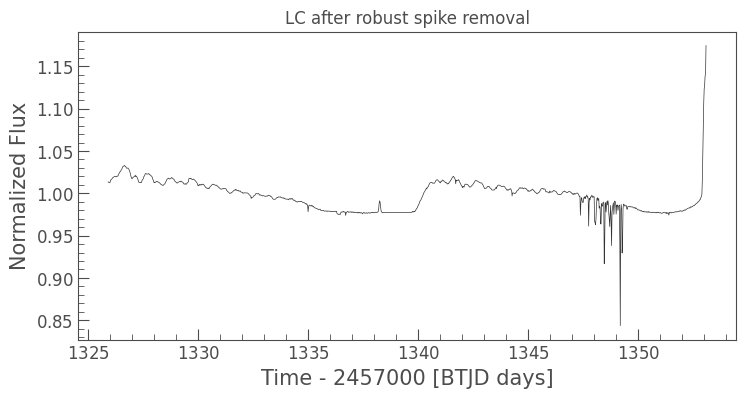

In [19]:
import numpy as np
import matplotlib.pyplot as plt

t = lc2.time.value
f = lc2.flux.value

# Step 1: 大范围 median smoothing（不影响 transit）
# 注意 window_length >> duration（本例用101）
smooth = lk.LightCurve(time=t, flux=f).flatten(window_length=101).flux.value

# Step 2: 差值
diff = np.abs(f - smooth)

# Step 3: robust sigma threshold
sigma = np.nanmedian(diff) + 5 * np.nanstd(diff)  # 5σ 阈值
mask = diff < sigma

lc_clean = lc2[mask]

# Step 4: 画图
plt.figure(figsize=(10,4))
lc_clean.plot()
plt.title("LC after robust spike removal")
plt.show()


TESSCut search result:
SearchResult containing 5 data products.

 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 01 2018 TESScut    1426 TIC 29857954      0.0
  1 TESS Sector 28 2020 TESScut     475 TIC 29857954      0.0
  2 TESS Sector 68 2023 TESScut     158 TIC 29857954      0.0
  3 TESS Sector 95 2025 TESScut     158 TIC 29857954      0.0
  4 TESS Sector 92 2025 TESScut     158 TIC 29857954      0.0

 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 01 2018 TESScut    1426 TIC 29857954      0.0)
  >> SECTOR = 1


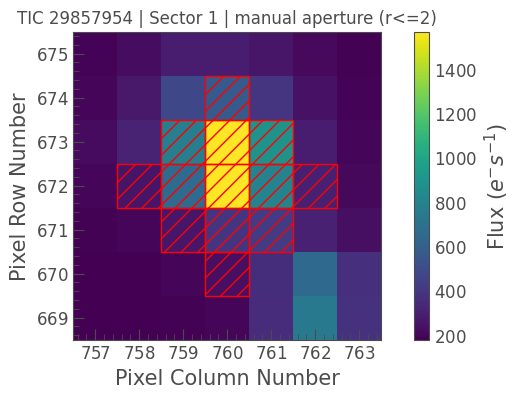

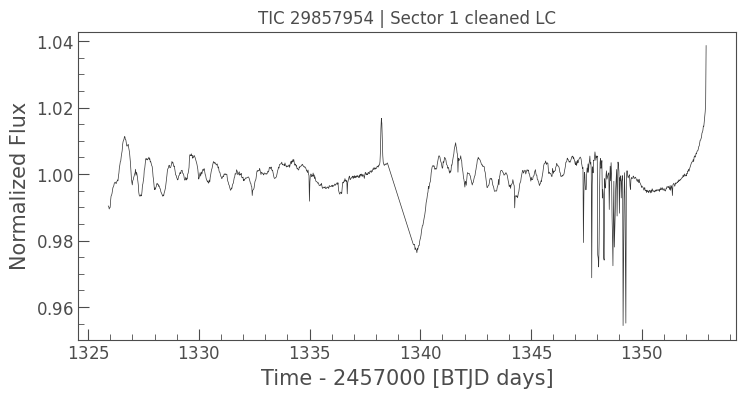


 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 28 2020 TESScut     475 TIC 29857954      0.0)
  >> SECTOR = 28


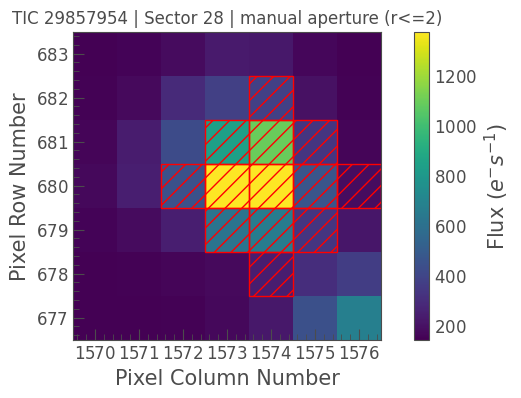

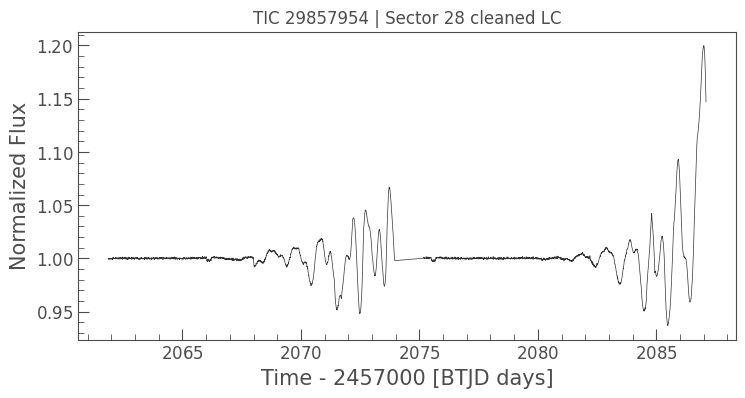


 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 68 2023 TESScut     158 TIC 29857954      0.0)
  >> SECTOR = 68


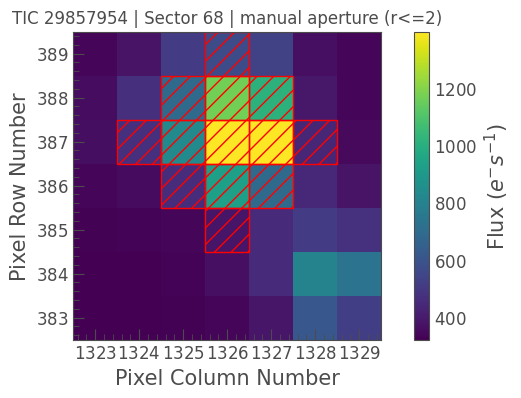

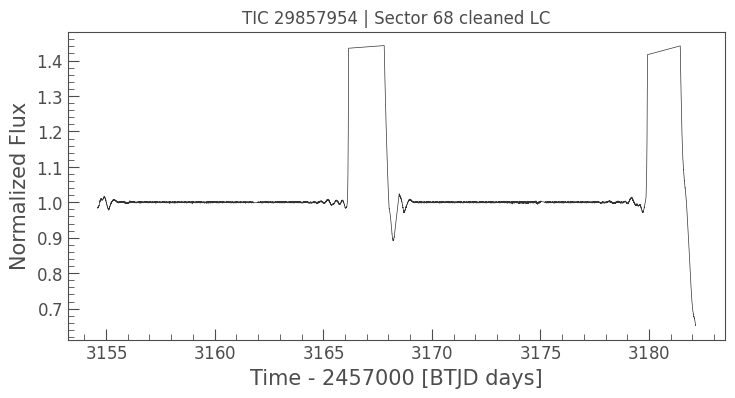


 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 95 2025 TESScut     158 TIC 29857954      0.0)
  >> SECTOR = 95


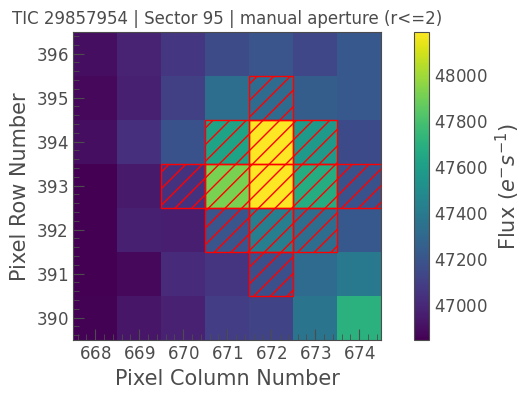

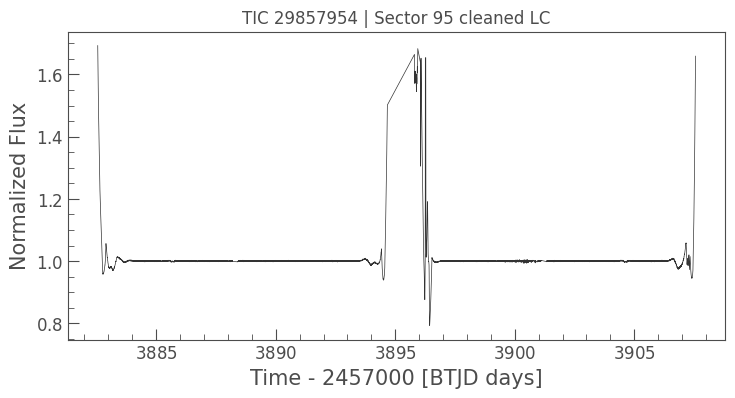


 #     mission     year  author exptime target_name  distance
                                   s                  arcsec 
--- -------------- ---- ------- ------- ------------ --------
  0 TESS Sector 92 2025 TESScut     158 TIC 29857954      0.0)
  >> SECTOR = 92


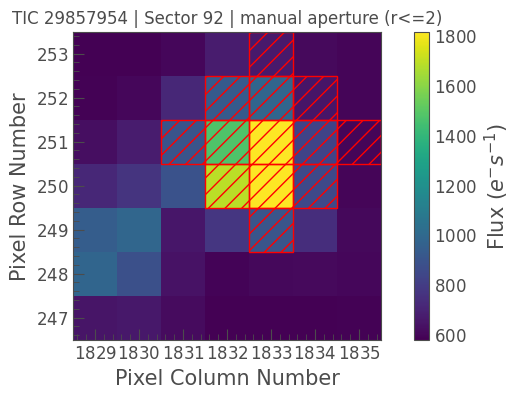

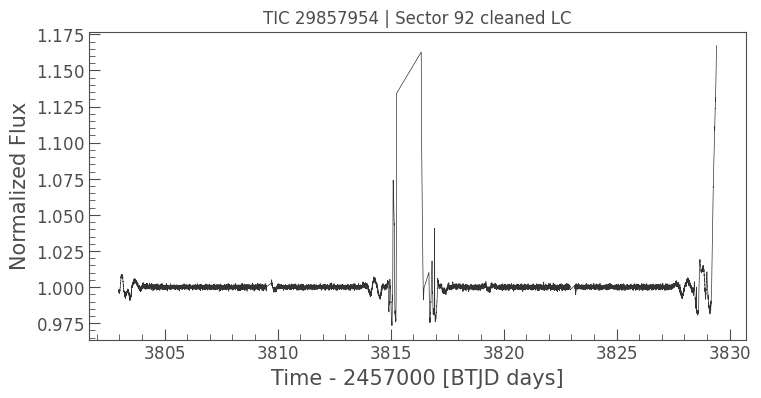

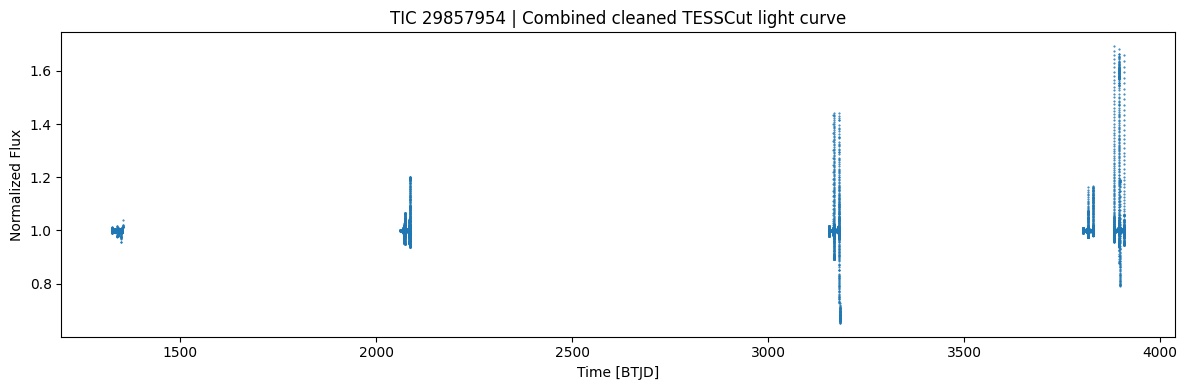

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk


# ===========================
# 0. 基本设置
# ===========================
tic_id = 29857954          # TOI-172
cutout_size = 7            # TESSCut 视场大小（7x7 像素，比 15 小很多）
ap_radius = 2              # 手动圆形 aperture 半径（单位：像素）
smooth_win_spike = 101     # 去 spike 时的平滑窗口长度（必须是奇数）
smooth_win_flat = 401      # 去趋势的平滑窗口长度
sigma_spike = 5            # spike 的 sigma 阈值
sigma_global_outlier = 8   # 全局离群点 sigma（非常大，主要防极端点）


# ===========================
# 1. 辅助函数：根据 TPF 生成手动圆形 aperture
# ===========================
def make_circular_aperture(tpf, radius=2):
    """
    根据 TPF 的 median 图像，找出最亮像素作为星的中心，
    然后画一个半径为 radius 像素的圆形 aperture。
    """
    # 对时间轴取中值，得到一张代表性的“平均图像”
    median_image = np.nanmedian(tpf.flux, axis=0)

    # 找到最亮像素作为中心
    y0, x0 = np.unravel_index(np.nanargmax(median_image), median_image.shape)

    ny, nx = median_image.shape
    Y, X = np.indices((ny, nx))
    r = np.sqrt((X - x0)**2 + (Y - y0)**2)

    aperture = r <= radius
    return aperture


# ===========================
# 2. 辅助函数：去掉 spike（不杀 transit）
# ===========================
def remove_spikes(lc, window_length=101, sigma_clip=5):
    """
    使用 median 平滑 + 差值 + sigma clipping 去掉瞬时 spike，
    尽量不动真正的 transit。
    """
    # 做一个大窗口的 flatten，得到平滑的光变（不去 trend，只相当于平滑）
    lc_smooth = lc.flatten(window_length=window_length)
    f_smooth = lc_smooth.flux.value

    f = lc.flux.value
    diff = np.abs(f - f_smooth)

    # robust sigma 阈值
    thr = np.nanmedian(diff) + sigma_clip * np.nanstd(diff)
    mask = diff < thr

    return lc[mask]


# ===========================
# 3. 下载所有 TESSCut TPF，并对每个 sector 做：aperture + 降噪 + 去趋势
# ===========================
search_tpf = lk.search_tesscut(f"TIC {tic_id}")
print("TESSCut search result:")
print(search_tpf)

clean_lcs = []

for i, res in enumerate(search_tpf):
    print("="*50)
    print(f"Downloading TPF {i}  ({res})")
    try:
        tpf = res.download(cutout_size=cutout_size)
    except Exception as e:
        print(f"  >> 下载失败: {e}")
        continue

    sector = tpf.meta.get("SECTOR", "Unknown")
    print(f"  >> SECTOR = {sector}")

    # 3.1 生成手动圆形 aperture
    aperture = make_circular_aperture(tpf, radius=ap_radius)

    # 画一下 TPF + aperture 看看
    tpf.plot(aperture_mask=aperture)
    plt.title(f"TIC {tic_id} | Sector {sector} | manual aperture (r<={ap_radius})")
    plt.show()

    # 3.2 提取光变
    lc = tpf.to_lightcurve(aperture_mask=aperture)
    lc = lc.remove_nans()

    # 3.3 去 spike
    lc = remove_spikes(lc, window_length=smooth_win_spike, sigma_clip=sigma_spike)

    # 3.4 归一化 + 去趋势 + 全局离群点
    lc = lc.normalize()
    lc = lc.flatten(window_length=smooth_win_flat)
    lc = lc.remove_outliers(sigma=sigma_global_outlier)

    # 画一下这一段 sector 的干净光变
    lc.plot()
    plt.title(f"TIC {tic_id} | Sector {sector} cleaned LC")
    plt.show()

    clean_lcs.append(lc)

# ===========================
# 4. 拼接所有 sector 的干净光变
# ===========================
if len(clean_lcs) == 0:
    raise RuntimeError("没有成功清洗的光变，请检查上面的输出。")

combined = clean_lcs[0]
for lc in clean_lcs[1:]:
    combined = combined.append(lc)

# 再做一次轻微 normalize，保证不同 sector 接得比较平滑
combined = combined.normalize()

# ===========================
# 5. 画出最终拼接后的完整光变
# ===========================
plt.figure(figsize=(12,4))
plt.plot(combined.time.value, combined.flux.value, ".", markersize=1)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title(f"TIC {tic_id} | Combined cleaned TESSCut light curve")
plt.tight_layout()
plt.show()

# （可选）保存到本地，方便后续做 BLS/TTV
# combined.to_fits("TIC_29857954_TESSCut_clean_combined.fits", overwrite=True)
# combined.to_pandas().to_csv("TIC_29857954_TESSCut_clean_combined.csv", index=False)


SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 28 2020   SPOC      20    29857954      0.0
  1 TESS Sector 28 2020   SPOC     120    29857954      0.0
  2 TESS Sector 68 2023   SPOC     120    29857954      0.0
  3 TESS Sector 92 2025   SPOC     120    29857954      0.0
  4 TESS Sector 95 2025   SPOC     120    29857954      0.0
missions:    mission    
--------------
TESS Sector 28
TESS Sector 28
TESS Sector 68
TESS Sector 92
TESS Sector 95
Sector 92 row index = 3
Downloading: SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 92 2025   SPOC     120    29857954      0.0


<Figure size 3000x1000 with 0 Axes>

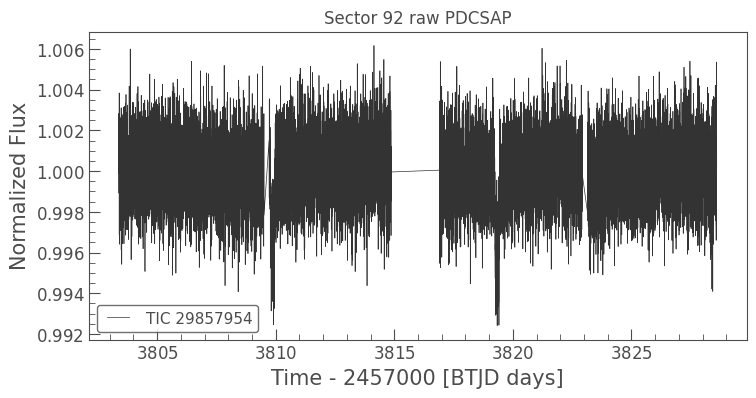

In [27]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

tic_id = 29857954

search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")
print(search)

# 1. mission 列是真实的字符串列
missions = search.table['mission']      # e.g. "TESS Sector 92"
exptimes = search.table['exptime']      # 20 or 120
print("missions:", missions)

# 2. 找 Sector 92
sector92_index = None
for i, m in enumerate(missions):
    if "Sector 92" in m:
        sector92_index = i
        break

if sector92_index is None:
    raise RuntimeError("Sector 92 not found!")

print("Sector 92 row index =", sector92_index)

# 3. 下载 Sector 92 对应的数据产品
sector92_row = search[sector92_index]
print("Downloading:", sector92_row)

lc92 = sector92_row.download(flux_column="pdcsap_flux").remove_nans().normalize()

plt.figure(figsize=(30,10))
lc92.plot()
plt.title("Sector 92 raw PDCSAP")
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 这里先用一个参考 ephemeris（之后你可以换成更精的）
T0_BJD = 2459359.90284   # 文献里的 T0
P = 9.476918             # 周期（天）
T0_BTJD = T0_BJD - 2457000

t = lc92.time.value

# 在当前时间范围内生成所有可能的 transit 中心
n_min = int(np.floor((t.min() - T0_BTJD) / P)) - 1
n_max = int(np.ceil((t.max() - T0_BTJD) / P)) + 1
ns = np.arange(n_min, n_max+1)
t_trans = T0_BTJD + ns * P
t_trans = t_trans[(t_trans > t.min()) & (t_trans < t.max())]

print("Expected transits in Sector 92 (BTJD):")
for tt in t_trans:
    print(f"  {tt:.5f}")


Expected transits in Sector 92 (BTJD):
  3809.87129
  3819.34821


In [29]:
def cut_transit_window(lc, t0, half_width=0.4, flatten_window=51):
    """
    从 lc 中截取以 t0 为中心、前后 half_width 天的片段，
    再做一次局部 flatten，返回一个新的 LightCurve。
    """
    t = lc.time.value
    mask = (t > t0 - half_width) & (t < t0 + half_width)
    lc_win = lc[mask]
    # 局部去趋势，避免大尺度起伏影响 transit 形状
    lc_win = lc_win.flatten(window_length=flatten_window)
    return lc_win


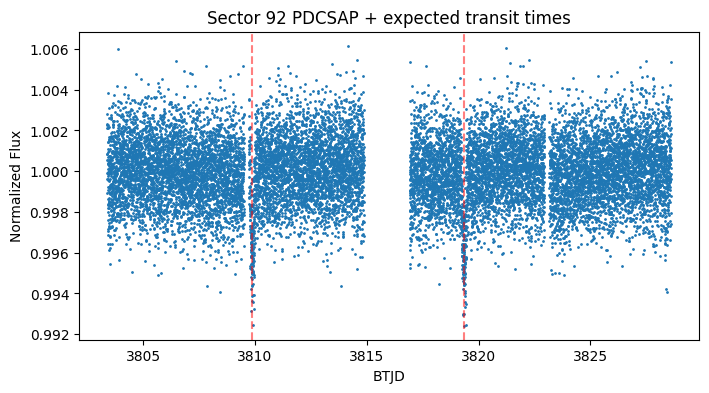

In [31]:
plt.figure(figsize=(8,4))
plt.plot(lc92.time.value, lc92.flux.value, ".", ms=2)

for tt in t_trans:    # 就是之前算出来的那些 t_trans
    plt.axvline(tt, color="r", alpha=0.5, ls="--")

plt.xlabel("BTJD")
plt.ylabel("Normalized Flux")
plt.title("Sector 92 PDCSAP + expected transit times")
plt.show()


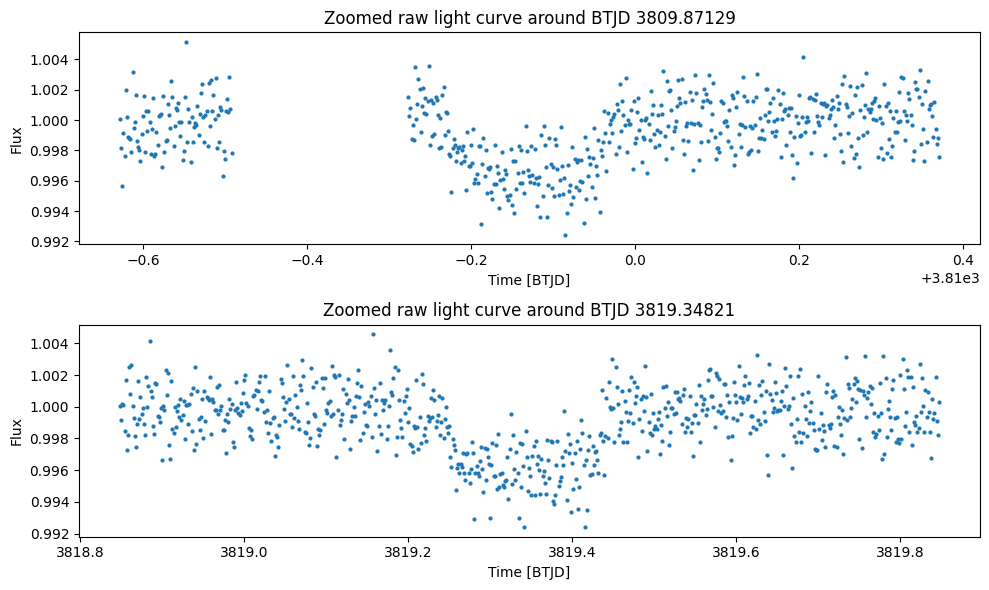

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# 要放大的两个时间点
t_list = [3809.87129, 3819.34821]

# 每段的放大宽度 (days)
half_width = 0.5   # 可改成 0.3 或 1.0 看不同效果

# 时间数组
t = lc92.time.value
f = lc92.flux.value

plt.figure(figsize=(10, 6))

for i, t0 in enumerate(t_list):
    mask = (t > t0 - half_width) & (t < t0 + half_width)

    plt.subplot(2, 1, i+1)
    plt.plot(t[mask], f[mask], ".", ms=4)
    plt.title(f"Zoomed raw light curve around BTJD {t0:.5f}")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")

plt.tight_layout()
plt.show()


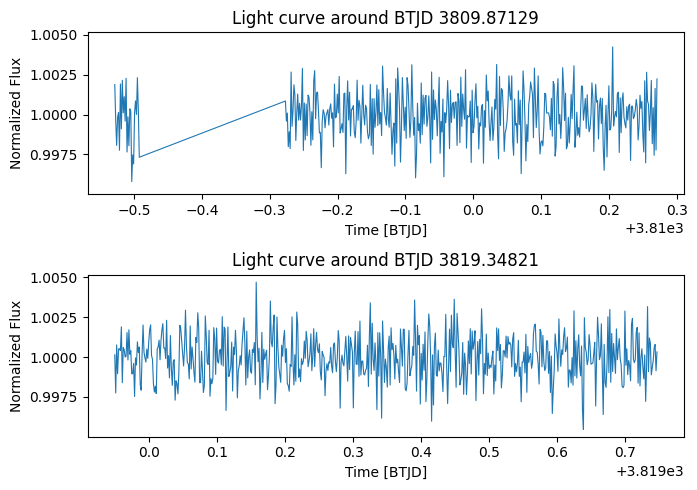

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 你关心的两个中心时间（BTJD）
t0_list = [3809.87129, 3819.34821]

# 截取窗口的半宽（单位：天），可以自己调，比如前后各 0.4 天
half_width = 0.4

t = lc92.time.value

fig, axes = plt.subplots(len(t0_list), 1, figsize=(7, 5), sharey=True)

for i, t0 in enumerate(t0_list):
    mask = (t > t0 - half_width) & (t < t0 + half_width)
    lc_win = lc92[mask]
    # 可选：做一个局部去趋势，让形状更清楚
    lc_win = lc_win.flatten(window_length=51)

    ax = axes[i] if len(t0_list) > 1 else axes
    ax.plot(lc_win.time.value, lc_win.flux.value, "-", lw=0.8)
    ax.set_title(f"Light curve around BTJD {t0:.5f}")
    ax.set_xlabel("Time [BTJD]")
    ax.set_ylabel("Normalized Flux")

plt.tight_layout()
plt.show()


SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 28 2020   SPOC      20    29857954      0.0
  1 TESS Sector 28 2020   SPOC     120    29857954      0.0
  2 TESS Sector 68 2023   SPOC     120    29857954      0.0
  3 TESS Sector 92 2025   SPOC     120    29857954      0.0
  4 TESS Sector 95 2025   SPOC     120    29857954      0.0
missions:    mission    
--------------
TESS Sector 28
TESS Sector 28
TESS Sector 68
TESS Sector 92
TESS Sector 95
Sector 92 row index = 3
Downloading: SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 92 2025   SPOC     120    29857954      0.0


<Figure size 3000x1000 with 0 Axes>

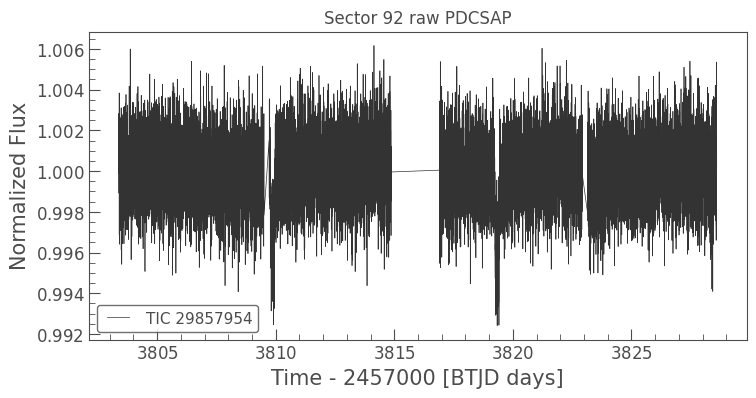

In [36]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

tic_id = 29857954

search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")
print(search)

# 1. mission 列是真实的字符串列
missions = search.table['mission']      # e.g. "TESS Sector 92"
exptimes = search.table['exptime']      # 20 or 120
print("missions:", missions)

# 2. 找 Sector 92
sector92_index = None
for i, m in enumerate(missions):
    if "Sector 92" in m:
        sector92_index = i
        break

if sector92_index is None:
    raise RuntimeError("Sector 92 not found!")

print("Sector 92 row index =", sector92_index)

# 3. 下载 Sector 92 对应的数据产品
sector92_row = search[sector92_index]
print("Downloading:", sector92_row)

lc92 = sector92_row.download(flux_column="pdcsap_flux").remove_nans().normalize()

plt.figure(figsize=(30,10))
lc92.plot()
plt.title("Sector 92 raw PDCSAP")
plt.show()



SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 28 2020   SPOC      20    29857954      0.0
  1 TESS Sector 28 2020   SPOC     120    29857954      0.0
  2 TESS Sector 68 2023   SPOC     120    29857954      0.0
  3 TESS Sector 92 2025   SPOC     120    29857954      0.0
  4 TESS Sector 95 2025   SPOC     120    29857954      0.0
Use row index for Sector 28: 1 SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 28 2020   SPOC     120    29857954      0.0


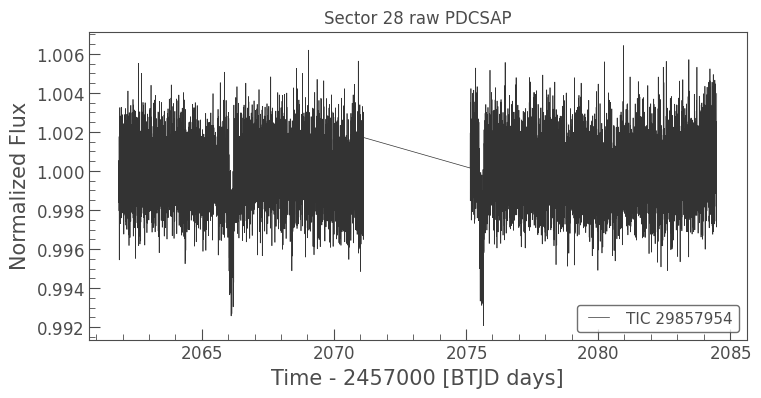

Expected transits in Sector 28 (BTJD):
  2066.10964
  2075.58684


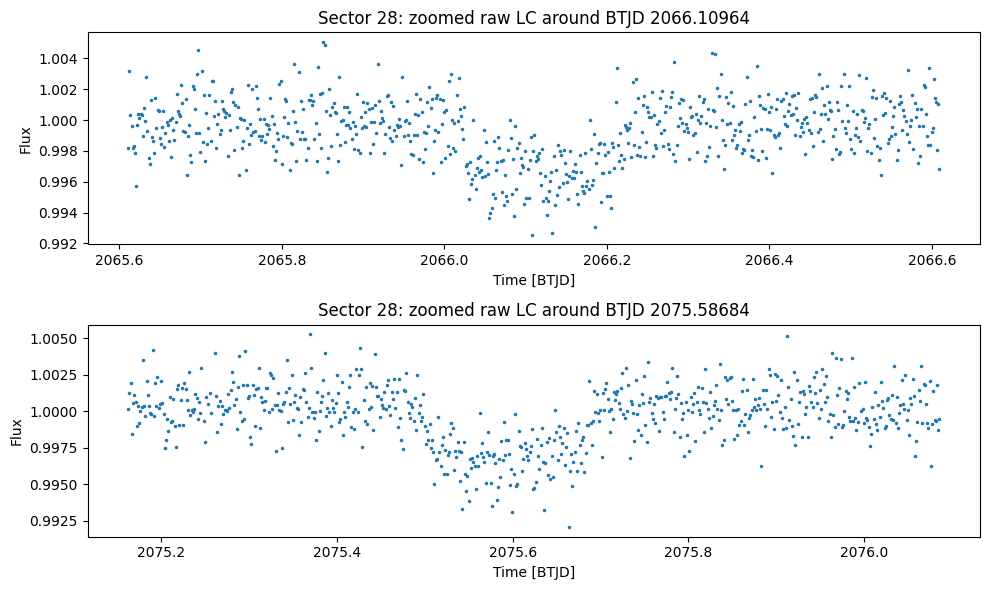

In [38]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

tic_id = 29857954

# ---------- 1. 搜索 SPOC 光变 ----------
search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")
print(search)

missions = search.table['mission']
exptimes = search.table['exptime']

# ---------- 2. 找到 Sector 28（这里选 120s 曝光） ----------
idx28 = None
for i, m in enumerate(missions):
    if ("Sector 28" in m) and (exptimes[i] == 120):
        idx28 = i
        break

if idx28 is None:
    raise RuntimeError("Sector 28 (120s) not found in SPOC results")

print("Use row index for Sector 28:", idx28, search[idx28])

# ---------- 3. 下载 Sector 28 的 PDCSAP 光变 ----------
lc28 = search[idx28].download(flux_column="pdcsap_flux")
lc28 = lc28.remove_nans().normalize()

# 先看一眼整条 Sector 28
lc28.plot()
plt.title("Sector 28 raw PDCSAP")
plt.show()

# ---------- 4. 用同一个 ephemeris 算 Sector 28 里的凌日时间 ----------
P = 9.4772
T0_BJD = 2459359.90284
T0_BTJD = T0_BJD - 2457000

t28 = lc28.time.value

n_min = int(np.floor((t28.min() - T0_BTJD) / P)) - 1
n_max = int(np.ceil((t28.max() - T0_BTJD) / P)) + 1
ns = np.arange(n_min, n_max+1)
t_trans_28 = T0_BTJD + ns * P
t_trans_28 = t_trans_28[(t_trans_28 > t28.min()) & (t_trans_28 < t28.max())]

print("Expected transits in Sector 28 (BTJD):")
for tt in t_trans_28:
    print(f"  {tt:.5f}")

# ---------- 5. 像刚才 Sector 92 一样：放大这些时间附近的原始光变 ----------
half_width = 0.5   # 前后各 0.5 天，你可以改成 0.3、0.2 试试看

plt.figure(figsize=(10, 3 * len(t_trans_28)))

for i, t0 in enumerate(t_trans_28):
    mask = (t28 > t0 - half_width) & (t28 < t0 + half_width)

    plt.subplot(len(t_trans_28), 1, i+1)
    plt.plot(t28[mask], lc28.flux.value[mask], ".", ms=3)
    plt.title(f"Sector 28: zoomed raw LC around BTJD {t0:.5f}")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")

plt.tight_layout()
plt.show()


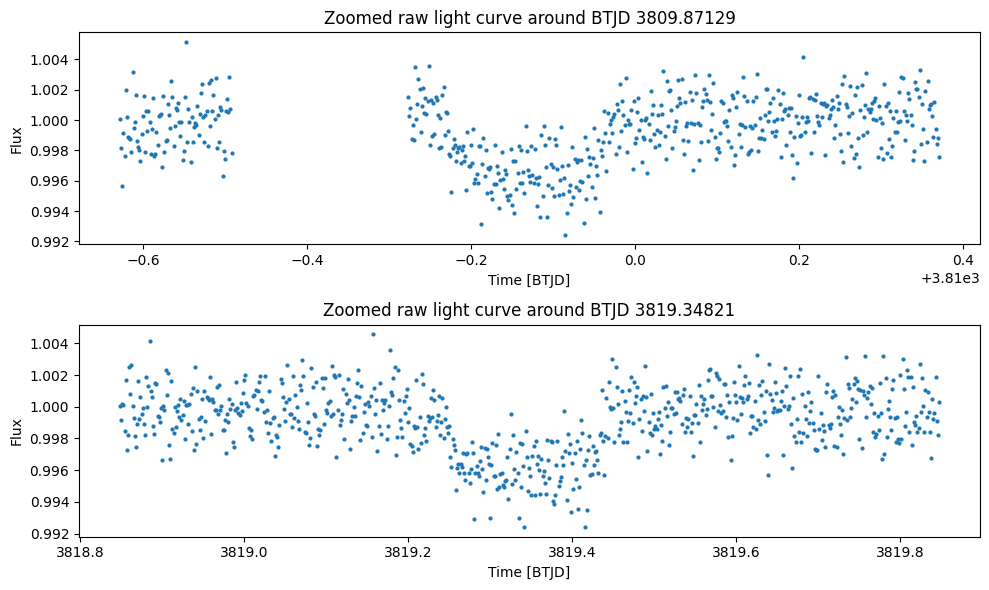

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 要放大的两个时间点
t_list = [3809.87129, 3819.34821]

# 每段的放大宽度 (days)
half_width = 0.5   # 可改成 0.3 或 1.0 看不同效果

# 时间数组
t = lc92.time.value
f = lc92.flux.value

plt.figure(figsize=(10, 6))

for i, t0 in enumerate(t_list):
    mask = (t > t0 - half_width) & (t < t0 + half_width)

    plt.subplot(2, 1, i+1)
    plt.plot(t[mask], f[mask], ".", ms=4)
    plt.title(f"Zoomed raw light curve around BTJD {t0:.5f}")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")

plt.tight_layout()
plt.show()


SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 28 2020   SPOC      20    29857954      0.0
  1 TESS Sector 28 2020   SPOC     120    29857954      0.0
  2 TESS Sector 68 2023   SPOC     120    29857954      0.0
  3 TESS Sector 92 2025   SPOC     120    29857954      0.0
  4 TESS Sector 95 2025   SPOC     120    29857954      0.0
Use row index for Sector 95: 4 SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 95 2025   SPOC     120    29857954      0.0


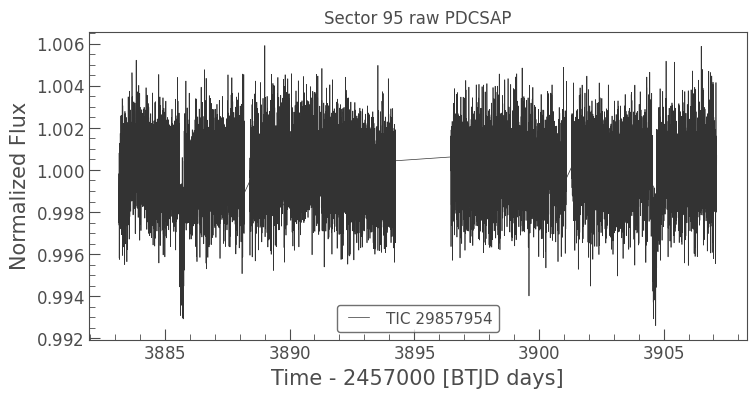

Expected transits in Sector 95 (BTJD):
  3885.73204
  3895.20924
  3904.68644


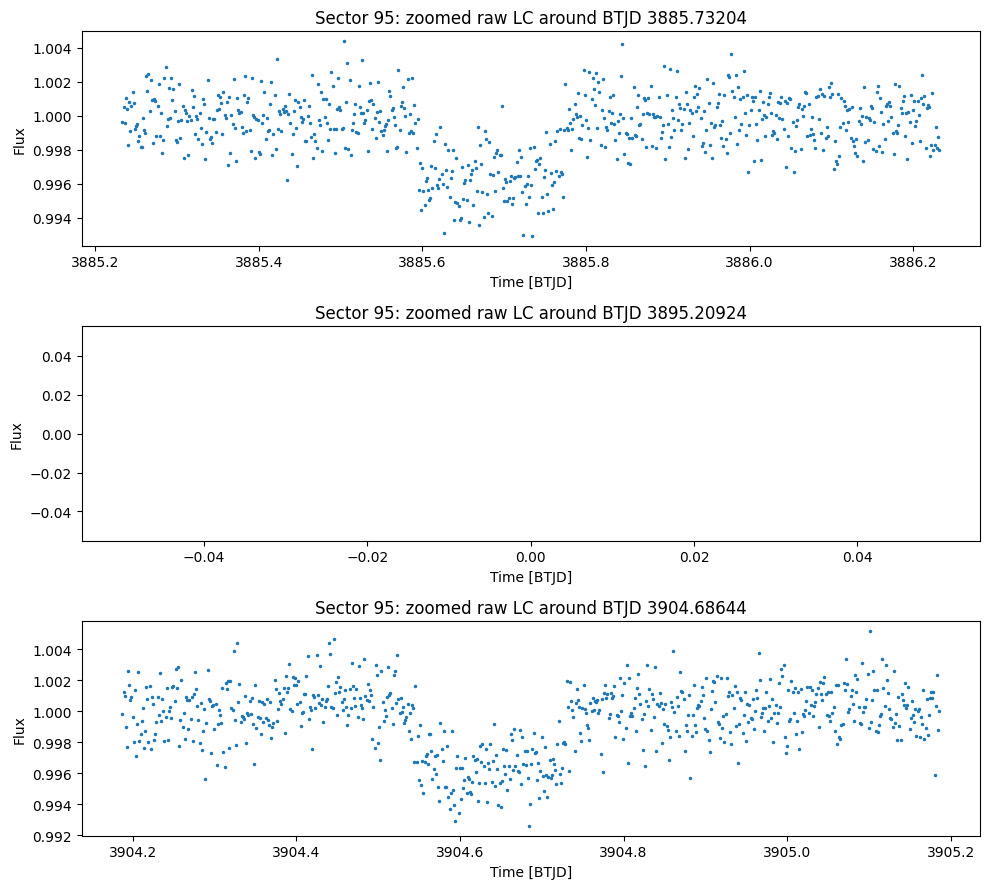

In [39]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

tic_id = 29857954

# ---------- 1. 搜索 SPOC 光变 ----------
search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")
print(search)

missions = search.table['mission']
exptimes = search.table['exptime']

# ---------- 2. 找到 Sector 95（这里选 120s 曝光） ----------
idx95 = None
for i, m in enumerate(missions):
    if ("Sector 95" in m) and (exptimes[i] == 120):
        idx95 = i
        break

if idx95 is None:
    raise RuntimeError("Sector 95 (120s) not found in SPOC results")

print("Use row index for Sector 95:", idx95, search[idx95])

# ---------- 3. 下载 Sector 95 的 PDCSAP 光变 ----------
lc95 = search[idx95].download(flux_column="pdcsap_flux")
lc95 = lc95.remove_nans().normalize()

# 先看一眼整条 Sector 95
lc95.plot()
plt.title("Sector 95 raw PDCSAP")
plt.show()

# ---------- 4. 用同一个 ephemeris 算 Sector 95 里的凌日时间 ----------
P = 9.4772
T0_BJD = 2459359.90284
T0_BTJD = T0_BJD - 2457000

t95 = lc95.time.value

n_min = int(np.floor((t95.min() - T0_BTJD) / P)) - 1
n_max = int(np.ceil((t95.max() - T0_BTJD) / P)) + 1
ns = np.arange(n_min, n_max+1)
t_trans_95 = T0_BTJD + ns * P
t_trans_95 = t_trans_95[(t_trans_95 > t95.min()) & (t_trans_95 < t95.max())]

print("Expected transits in Sector 95 (BTJD):")
for tt in t_trans_95:
    print(f"  {tt:.5f}")

# ---------- 5. 像刚才 Sector 92 一样：放大这些时间附近的原始光变 ----------
half_width = 0.5   # 前后各 0.5 天，你可以改成 0.3、0.2 试试看

plt.figure(figsize=(10, 3 * len(t_trans_95)))

for i, t0 in enumerate(t_trans_95):
    mask = (t95 > t0 - half_width) & (t95 < t0 + half_width)

    plt.subplot(len(t_trans_95), 1, i+1)
    plt.plot(t95[mask], lc95.flux.value[mask], ".", ms=3)
    plt.title(f"Sector 95: zoomed raw LC around BTJD {t0:.5f}")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")

plt.tight_layout()
plt.show()


SearchResult containing 21 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 28 2020              SPOC      20    29857954      0.0
  1 TESS Sector 28 2020              SPOC     120    29857954      0.0
  2 TESS Sector 68 2023              SPOC     120    29857954      0.0
  3 TESS Sector 95 2025              SPOC     120    29857954      0.0
  4 TESS Sector 92 2025              SPOC     120    29857954      0.0
  5 TESS Sector 01 2018         TESS-SPOC    1800    29857954      0.0
  6 TESS Sector 28 2020         TESS-SPOC     600    29857954      0.0
  7 TESS Sector 68 2023         TESS-SPOC     200    29857954      0.0
  8 TESS Sector 01 2018               QLP    1800    29857954      0.0
  9 TESS Sector 28 2020               QLP     600    29857954      0.0
 10 TESS Sector 68 2023           

<Figure size 1000x400 with 0 Axes>

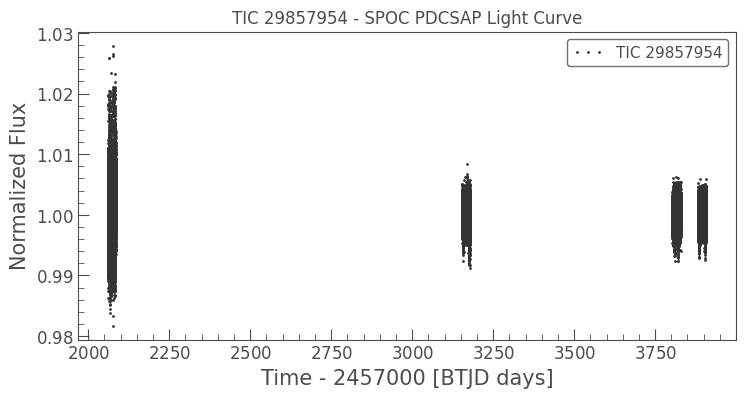

<Figure size 1000x400 with 0 Axes>

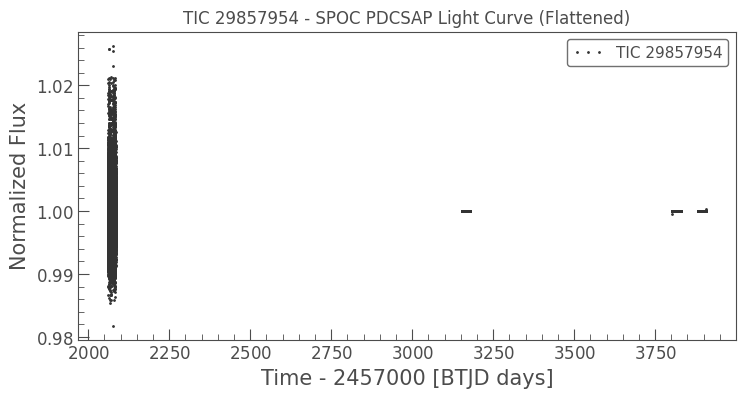

In [40]:
import lightkurve as lk
import matplotlib.pyplot as plt

tic_id = 29857954

# 1. 搜索 TESS 光变曲线
search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")
print(search)

# 2. 只要 SPOC 的产品（自动忽略 QLP）
spoc_search = search[search.author == "SPOC"]
print(spoc_search)

# 如果 spoc_search 为空，就说明这颗星没有 SPOC LC
if len(spoc_search) == 0:
    raise RuntimeError("No SPOC light curves found for this TIC ID.")

# 3. 下载所有 SPOC 光变曲线（所有 sectors）
lc_collection = spoc_search.download_all()

# 4. 把所有 sector 接在一起 + 去掉 NaN
lc_all = lc_collection.stitch().remove_nans()

# 5. 归一化 + 去趋势（flatten）
lc_flat = lc_all.normalize().flatten(window_length=401)

# 6. 画图：原始 PDCSAP（已系统校正）+ flatten 后的
plt.figure(figsize=(10,4))
lc_all.plot(marker='.', lw=0, ms=2)
plt.title(f"TIC {tic_id} - SPOC PDCSAP Light Curve")

plt.figure(figsize=(10,4))
lc_flat.plot(marker='.', lw=0, ms=2)
plt.title(f"TIC {tic_id} - SPOC PDCSAP Light Curve (Flattened)")
plt.show()


In [41]:
import lightkurve as lk

def get_spoc_lc_by_sector(tic_id, normalize=True, flatten=True, window_length=401):
    """
    返回一个 dict:
        { sector_number: lightkurve.LightCurve 对象 }
    每个 LC 都只包含该 sector 的数据（已去 NaN, 可选 flatten）
    """
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")
    spoc_search = search[search.author == "SPOC"]
    if len(spoc_search) == 0:
        raise RuntimeError(f"No SPOC light curves found for TIC {tic_id}")

    lcs_by_sector = {}

    for i, res in enumerate(spoc_search):
        sector = spoc_search.table["sector"][i]
        lc = res.download().remove_nans()

        if normalize:
            lc = lc.normalize()
        if flatten:
            lc = lc.flatten(window_length=window_length)

        lcs_by_sector[sector] = lc

    return lcs_by_sector

# 用法：
tic_id = 29857954
lcs_by_sector = get_spoc_lc_by_sector(tic_id)
print(lcs_by_sector.keys())   # 比如 dict_keys([1, 28, 55, 56]) 之类


KeyError: 'sector'